In [28]:
#check gpu
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.8.0
True


In [29]:
# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tqdm import tqdm
import matplotlib.pyplot as plt 

## Data Preparation

In [30]:
# 1. Load and Preprocess Data
csv_path = 'data-vn-20230228\stock-historical-data'

keywords = [
    "ABB", "ACB", "BID", "CTG", "EIB", "BVB", "HDB", "KLB", "LPB", "MBB", "MSB",
    "NAB", "BAB", "NVB", "OCB", "PGB", "SSB", "SGB", "SHB", "STB", "TCB", "TPB",
    "VAB", "VCB", "VIB", "VPB", "VBB"
]

# Load data
df_list = []
for file in os.listdir(csv_path):
    if any(keyword in file for keyword in keywords) and file.endswith('.csv'):
        file_path = os.path.join(csv_path, file)
        data = pd.read_csv(file_path, on_bad_lines='skip').dropna()
        data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
        df_list.append(data)

# Add Technical Indicators
def add_technical_indicators(df):
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

df_list = [add_technical_indicators(df) for df in df_list]

# Drop rows with missing values due to rolling calculations
df_list = [df.dropna().reset_index(drop=True) for df in df_list]

# Split into Train, Validation, and Test Sets
split_date_train = pd.Timestamp('2020-01-01')
split_date_val = pd.Timestamp('2021-01-01')
split_date_buffer = pd.Timestamp('2021-02-01')  # Buffer period

df_train_list, df_val_list, df_test_list = [], [], []
for df in df_list:
    train = df.loc[df['TradingDate'] < split_date_train]
    temp_test = df.loc[df['TradingDate'] >= split_date_train]
    val = temp_test.loc[temp_test['TradingDate'] < split_date_val]
    test = temp_test.loc[temp_test['TradingDate'] >= split_date_buffer]
    df_train_list.append(train)
    df_val_list.append(val)
    df_test_list.append(test)

C:\Users\nhata\AppData\Local\Temp\ipykernel_13520\3542196549.py:16: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_13520\3542196549.py:16: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_13520\3542196549.py:16: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_13520\3542196549.py:16: UserWarning

In [31]:
# 2. Prepare Time Window Data
def create_time_window_samples(df_list, window_size=30):
    X_data, y_data = [], []
    for df in tqdm(df_list, desc="Processing DataFrames"):
        for i in range(len(df) - window_size):
            window = [df.iloc[i+j, 1:6].values for j in range(window_size)]  # Open, High, Low, Close, Volume
            label = df.iloc[i + window_size, 1]  # Open Price as label
            X_data.append(window)
            y_data.append(label)
    return np.array(X_data), np.array(y_data)

window_size = 30
X_train, y_train = create_time_window_samples(df_train_list, window_size)
X_val, y_val = create_time_window_samples(df_val_list, window_size)
X_test, y_test = create_time_window_samples(df_test_list, window_size)

# Min-Max Normalize Data
def min_max_normalize(X_data, y_data=None):
    X_norm = np.zeros_like(X_data)
    y_norm = np.zeros_like(y_data) if y_data is not None else None
    X_min_max, y_min_max = [], []

    for i in range(len(X_data)):
        sample_min_max = []
        for j in range(X_data.shape[2]):
            min_val, max_val = X_data[i, :, j].min(), X_data[i, :, j].max()
            sample_min_max.append((min_val, max_val))
            X_norm[i, :, j] = (X_data[i, :, j] - min_val) / (max_val - min_val) if max_val > min_val else 0
        X_min_max.append(sample_min_max)
        if y_data is not None:
            min_label, max_label = min(X_data[i, :, 0]), max(X_data[i, :, 0])  # Use Open Price
            y_norm[i] = (y_data[i] - min_label) / (max_label - min_label) if max_label > min_label else 0
            y_min_max.append((min_label, max_label))
    return X_norm, y_norm, X_min_max, y_min_max

X_train_norm, y_train_norm, X_train_min_max, y_train_min_max = min_max_normalize(X_train, y_train)
X_val_norm, y_val_norm, X_val_min_max, y_val_min_max = min_max_normalize(X_val, y_val)
X_test_norm, y_test_norm, X_test_min_max, y_test_min_max = min_max_normalize(X_test, y_test)

Processing DataFrames: 100%|██████████| 27/27 [00:18<00:00,  1.49it/s]


In [32]:
#  convert to tensor
X_train_norm = tf.convert_to_tensor(X_train_norm, dtype=tf.float32)
y_train_norm = tf.convert_to_tensor(y_train_norm, dtype=tf.float32)
X_val_norm = tf.convert_to_tensor(X_val_norm, dtype=tf.float32)
y_val_norm = tf.convert_to_tensor(y_val_norm, dtype=tf.float32)
X_test_norm = tf.convert_to_tensor(X_test_norm, dtype=tf.float32)
y_test_norm = tf.convert_to_tensor(y_test_norm, dtype=tf.float32)

## Choose threshold

In [33]:
# Define the Conv1D model with Sigmoid Output
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, X_train_norm.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for probability output
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define binary labels for sell signals
# A sell signal is generated if the next day's price is higher than the average of the past window
y_train_binary_sell = (y_train > np.max(X_train[:, :, 0], axis=1)).astype(int)
# threshold = np.percentile(X_train[:, :, 0], 90, axis=1)
# y_train_binary_sell = (y_train > threshold).astype(int)
y_val_binary_sell = (y_val > np.max(X_val[:, :, 0], axis=1)).astype(int)
y_test_binary_sell = (y_test > np.max(X_test[:, :, 0], axis=1)).astype(int)

# Compile the model (reuse the same model architecture)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for selling signals
history_sell = model.fit(
    X_train_norm, y_train_binary_sell,
    validation_data=(X_val_norm, y_val_binary_sell),
    epochs=20, batch_size=2048
)

# Make predictions for selling signals
y_pred_prob_sell = model.predict(X_test_norm).flatten()
y_pred_binary_sell = (y_pred_prob_sell > 0.3552).astype(int)  # Convert probabilities to binary labels (0 or 1)
# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(y_test_binary_sell, y_pred_prob_sell)
# best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall))]
# y_pred_binary_sell = (y_pred_prob_sell > best_threshold).astype(int)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 28, 64)            1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               114816    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate model for selling signals
accuracy_sell = accuracy_score(y_test_binary_sell, y_pred_binary_sell)
precision_sell = precision_score(y_test_binary_sell, y_pred_binary_sell)
recall_sell = recall_score(y_test_binary_sell, y_pred_binary_sell)
f1_sell = f1_score(y_test_binary_sell, y_pred_binary_sell)

# Print evaluation metrics for selling signals
print("\nEvaluation Metrics for Selling Signals:")
print(f"Accuracy: {accuracy_sell:.4f}")
print(f"Precision: {precision_sell:.4f}")
print(f"Recall: {recall_sell:.4f}")
print(f"F1 Score: {f1_sell:.4f}")


Evaluation Metrics for Selling Signals:
Accuracy: 0.9320
Precision: 0.5093
Recall: 0.8431
F1 Score: 0.6350


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_threshold_metrics(y_test_binary, y_pred_prob, thresholds=np.linspace(0, 1, 100)):
    """
    Plots Precision, Recall, and F1 Score against thresholds.
    
    Args:
    - y_test_binary: True binary labels.
    - y_pred_prob: Predicted probabilities for the positive class.
    - thresholds: Array of thresholds to evaluate (default: np.linspace(0, 1, 100)).
    
    Returns:
    - best_threshold: The threshold with the highest F1 score.
    """
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in thresholds:
        y_pred_binary = (y_pred_prob > threshold).astype(int)
        precision = precision_score(y_test_binary, y_pred_binary)
        recall = recall_score(y_test_binary, y_pred_binary)
        f1 = f1_score(y_test_binary, y_pred_binary)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Find the threshold that maximizes F1 Score
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1_score = max(f1_scores)

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision', color='blue')
    plt.plot(thresholds, recalls, label='Recall', color='green')
    plt.plot(thresholds, f1_scores, label='F1 Score', color='red')
    plt.axvline(x=best_threshold, color='orange', linestyle='--', label=f'Best Threshold: {best_threshold:.4f}')
    plt.title('Precision, Recall, and F1 Score vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best F1 Score: {best_f1_score:.4f}")

    return best_threshold

c:\Users\nhata\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nhata\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nhata\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nhata\anaconda3\env

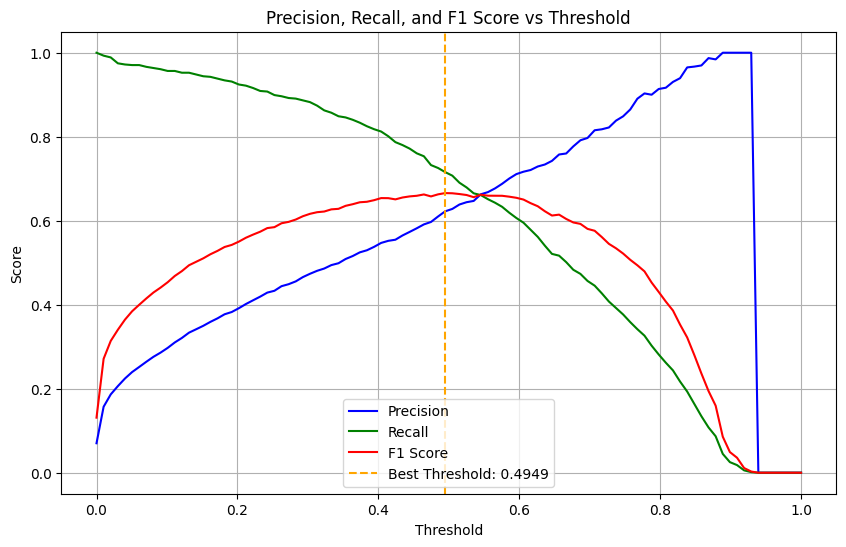

Best Threshold: 0.4949
Best F1 Score: 0.6658

Evaluation Metrics at Optimal Threshold:
Accuracy: 0.9496
Precision: 0.6224
Recall: 0.7157
F1 Score: 0.6658


In [36]:
# Example Variables
# y_test_binary_sell: True binary labels for selling signals
# y_pred_prob_sell: Predicted probabilities for selling signals

# Plot threshold metrics and find the optimal threshold
optimal_threshold = plot_threshold_metrics(y_test_binary_sell, y_pred_prob_sell)

# Use the optimal threshold for classification
y_pred_binary_sell = (y_pred_prob_sell > optimal_threshold).astype(int)

# Re-evaluate metrics
accuracy_sell = accuracy_score(y_test_binary_sell, y_pred_binary_sell)
precision_sell = precision_score(y_test_binary_sell, y_pred_binary_sell)
recall_sell = recall_score(y_test_binary_sell, y_pred_binary_sell)
f1_sell = f1_score(y_test_binary_sell, y_pred_binary_sell)

# Print evaluation metrics
print("\nEvaluation Metrics at Optimal Threshold:")
print(f"Accuracy: {accuracy_sell:.4f}")
print(f"Precision: {precision_sell:.4f}")
print(f"Recall: {recall_sell:.4f}")
print(f"F1 Score: {f1_sell:.4f}")


## Train models

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to build the Conv1D model
def build_conv1d_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
        LSTM(64, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to build the GRU model
def build_gru_model(input_shape):
    model = Sequential([
        GRU(128, activation='tanh', return_sequences=True, input_shape=input_shape),
        GRU(64, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Function to train the model
def train_model(model, X_train, y_train, X_val, y_val, model_name):
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=2048,
        callbacks=[early_stopping],
        verbose=1
    )
    print(f"\n{model_name} Training Complete.")
    return model, history

# Function to evaluate the model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred_prob = model.predict(X_test).flatten()
    y_pred_binary = (y_pred_prob > 0.3552).astype(int)  # Use best threshold from earlier
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return y_pred_binary

# # Input Shape
# input_shape = (X_train_norm.shape[1], X_train_norm.shape[2])

# # Train LSTM Model
# lstm_model = build_lstm_model(input_shape)
# lstm_model, lstm_history = train_model(lstm_model, X_train_norm, y_train_binary_sell, X_val_norm, y_val_binary_sell, "LSTM")

# # Train GRU Model
# gru_model = build_gru_model(input_shape)
# gru_model, gru_history = train_model(gru_model, X_train_norm, y_train_binary_sell, X_val_norm, y_val_binary_sell, "GRU")

# # Evaluate Models
# lstm_predictions = evaluate_model(lstm_model, X_test_norm, y_test_binary_sell, "LSTM")
# gru_predictions = evaluate_model(gru_model, X_test_norm, y_test_binary_sell, "GRU")


In [38]:
print("X_train_norm shape:", X_train_norm.shape)  # Should be (num_samples, time_steps, features)
print("y_train_binary_sell shape:", y_train_binary_sell.shape)  # Should be (num_samples,)


X_train_norm shape: (21455, 30, 5)
y_train_binary_sell shape: (21455,)


In [39]:
print("Original y_train shape:", y_train.shape)  # Should be larger than X_train due to the time window offset
print("Expected y_train shape after time windowing:", X_train_norm.shape[0])


Original y_train shape: (21455,)
Expected y_train shape after time windowing: 21455


In [40]:
# Generate binary labels for sell signals
y_train_binary_sell = (y_train > np.max(X_train[:, :, 0], axis=1)).astype(int)
y_val_binary_sell = (y_val > np.max(X_val[:, :, 0], axis=1)).astype(int)
y_test_binary_sell = (y_test > np.max(X_test[:, :, 0], axis=1)).astype(int)

# Validate alignment
print("X_train_norm shape:", X_train_norm.shape)
print("y_train_binary_sell shape:", y_train_binary_sell.shape)
assert X_train_norm.shape[0] == y_train_binary_sell.shape[0]

# Train COnv1D Model
conv1d_model = build_conv1d_model(input_shape=(window_size, X_train_norm.shape[2]))
conv1d_model, conv1d_history = train_model(conv1d_model, X_train_norm, y_train_binary_sell, X_val_norm, y_val_binary_sell, "Conv1D")

# Train LSTM Model
lstm_model = build_lstm_model(input_shape=(window_size, X_train_norm.shape[2]))
lstm_model, lstm_history = train_model(lstm_model, X_train_norm, y_train_binary_sell, X_val_norm, y_val_binary_sell, "LSTM")

# Train GRU Model
gru_model = build_gru_model(input_shape=(window_size, X_train_norm.shape[2]))
gru_model, gru_history = train_model(gru_model, X_train_norm, y_train_binary_sell, X_val_norm, y_val_binary_sell, "GRU")


X_train_norm shape: (21455, 30, 5)
y_train_binary_sell shape: (21455,)
Epoch 1/20
11/11 [==============================] - 0s 16ms/step - loss: 0.3507 - accuracy: 0.8784 - val_loss: 0.4271 - val_accuracy: 0.8943
Epoch 2/20
11/11 [==============================] - 0s 9ms/step - loss: 0.2422 - accuracy: 0.9319 - val_loss: 0.3013 - val_accuracy: 0.8943
Epoch 3/20
11/11 [==============================] - 0s 9ms/step - loss: 0.2213 - accuracy: 0.9319 - val_loss: 0.2971 - val_accuracy: 0.8943
Epoch 4/20
11/11 [==============================] - 0s 9ms/step - loss: 0.2084 - accuracy: 0.9319 - val_loss: 0.2827 - val_accuracy: 0.8943
Epoch 5/20
11/11 [==============================] - 0s 9ms/step - loss: 0.1989 - accuracy: 0.9319 - val_loss: 0.2739 - val_accuracy: 0.8943
Epoch 6/20
11/11 [==============================] - 0s 8ms/step - loss: 0.1904 - accuracy: 0.9319 - val_loss: 0.2583 - val_accuracy: 0.8943
Epoch 7/20
11/11 [==============================] - 0s 11ms/step - loss: 0.1808 - accura

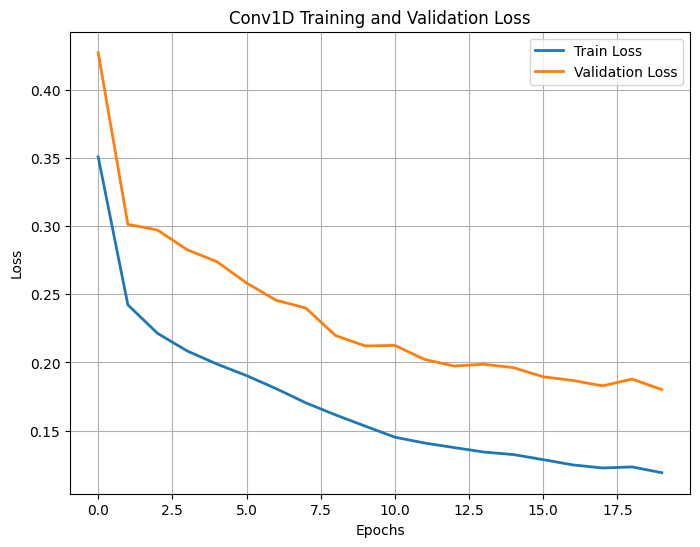

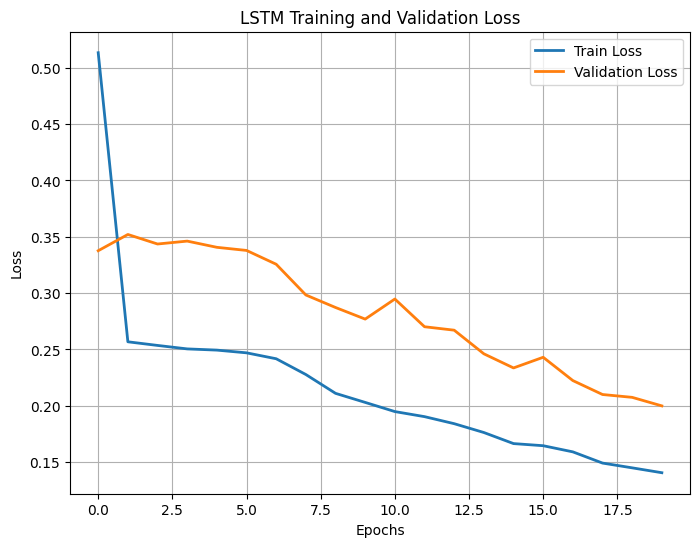

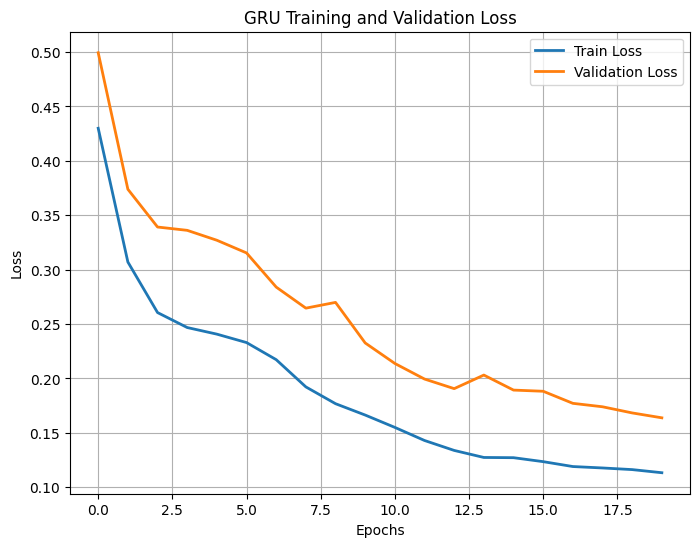

In [41]:
import matplotlib.pyplot as plt

# Function to plot training and validation loss
def plot_training_history(history, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for Conv1D
plot_training_history(conv1d_history, "Conv1D")

# Plot for LSTM
plot_training_history(lstm_history, "LSTM")

# Plot for GRU
plot_training_history(gru_history, "GRU")


## Test and evaluate models

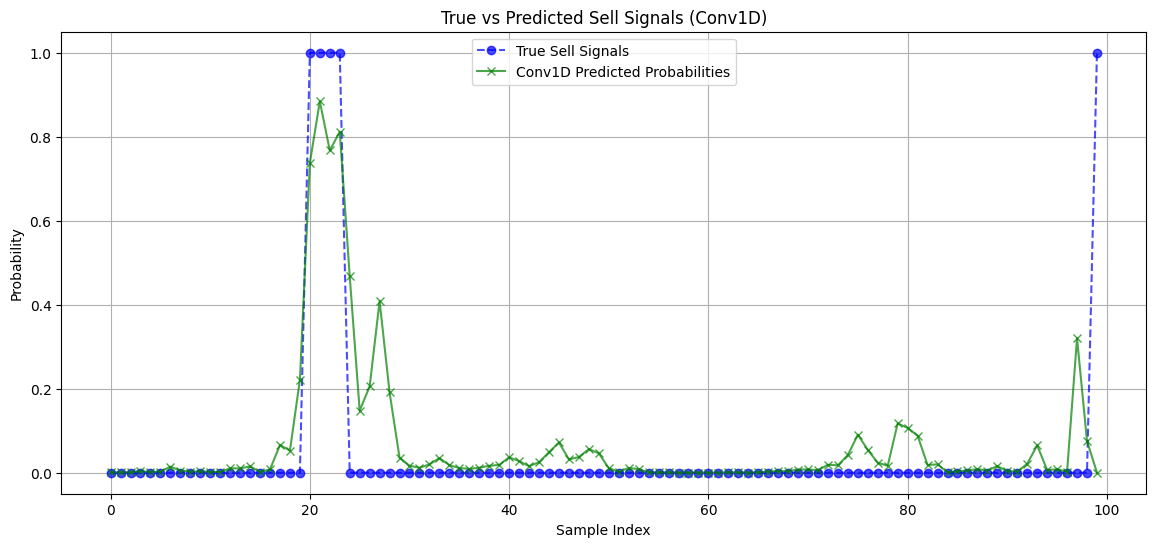

In [42]:
import matplotlib.pyplot as plt

# Conv1D Predictions vs True Sell Signals
plt.figure(figsize=(14, 6))
plt.plot(range(100), y_test_binary_sell[:100], label='True Sell Signals', marker='o', linestyle='--', color='blue', alpha=0.7)
plt.plot(range(100), model.predict(X_test_norm).flatten()[:100], label='Conv1D Predicted Probabilities', marker='x', linestyle='-', color='green', alpha=0.7)
plt.title("True vs Predicted Sell Signals (Conv1D)")
plt.xlabel("Sample Index")
plt.ylabel("Probability")
plt.legend()
plt.grid()
plt.show()

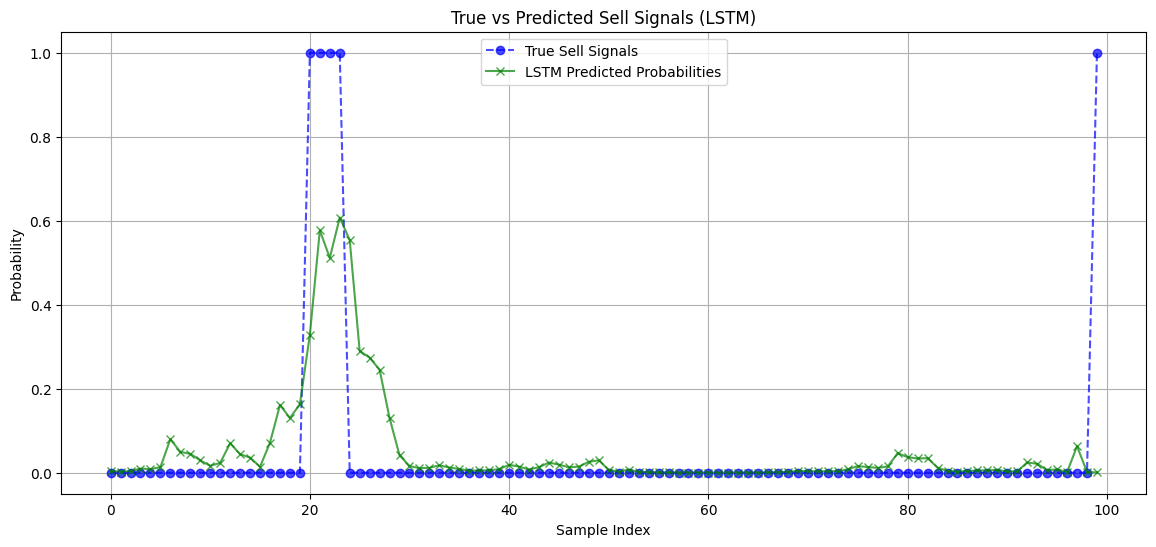

In [43]:
import matplotlib.pyplot as plt

# LSTM Predictions vs True Sell Signals
plt.figure(figsize=(14, 6))
plt.plot(range(100), y_test_binary_sell[:100], label='True Sell Signals', marker='o', linestyle='--', color='blue', alpha=0.7)
plt.plot(range(100), lstm_model.predict(X_test_norm).flatten()[:100], label='LSTM Predicted Probabilities', marker='x', linestyle='-', color='green', alpha=0.7)
plt.title("True vs Predicted Sell Signals (LSTM)")
plt.xlabel("Sample Index")
plt.ylabel("Probability")
plt.legend()
plt.grid()
plt.show()

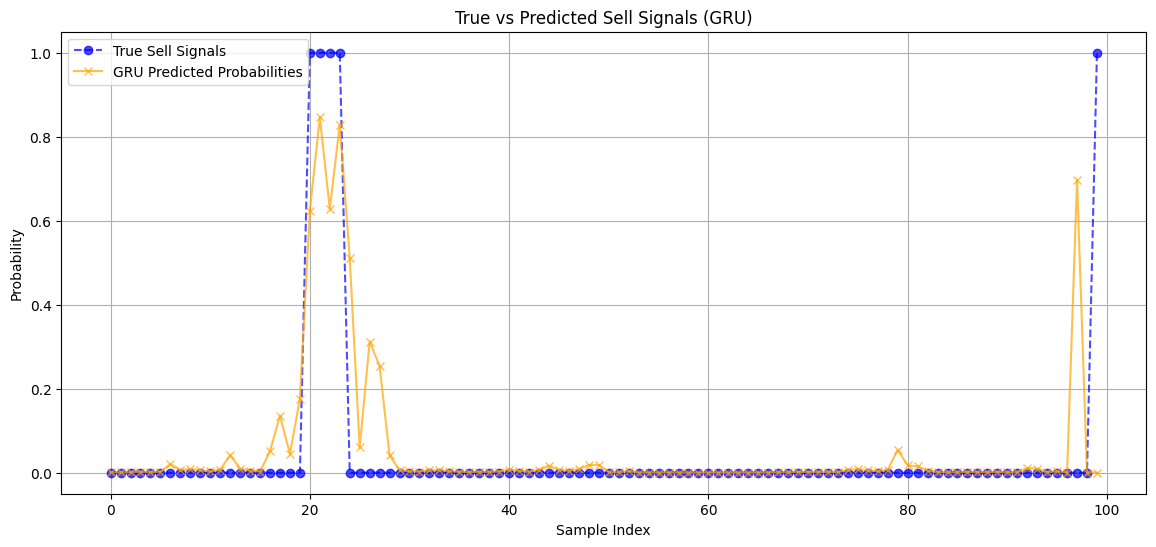

In [44]:
# GRU Predictions vs True Sell Signals
plt.figure(figsize=(14, 6))
plt.plot(range(100), y_test_binary_sell[:100], label='True Sell Signals', marker='o', linestyle='--', color='blue', alpha=0.7)
plt.plot(range(100), gru_model.predict(X_test_norm).flatten()[:100], label='GRU Predicted Probabilities', marker='x', linestyle='-', color='orange', alpha=0.7)
plt.title("True vs Predicted Sell Signals (GRU)")
plt.xlabel("Sample Index")
plt.ylabel("Probability")
plt.legend()
plt.grid()
plt.show()

In [45]:
# Evaluate Conv1D Model
conv1d_predictions = evaluate_model(conv1d_model, X_test_norm, y_test_binary_sell, "Conv1D")



Conv1D Evaluation:
Accuracy: 0.9456
Precision: 0.5915
Recall: 0.7241
F1 Score: 0.6511


In [46]:
# # Evaluate Models
lstm_predictions = evaluate_model(lstm_model, X_test_norm, y_test_binary_sell, "LSTM")


LSTM Evaluation:
Accuracy: 0.9479
Precision: 0.7009
Recall: 0.4496
F1 Score: 0.5478


In [47]:
gru_predictions = evaluate_model(gru_model, X_test_norm, y_test_binary_sell, "GRU")


GRU Evaluation:
Accuracy: 0.9621
Precision: 0.7455
Recall: 0.6975
F1 Score: 0.7207
